# Import Libraries

In [1]:
import os
from pathlib import Path

### Connect Neo4J

In [2]:
from neo4j import GraphDatabase, RoutingControl

URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "password")

In [3]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [4]:
from yfiles_jupyter_graphs import GraphWidget
from ipywidgets import Layout

# Define dirs

In [8]:
DataDir = Path(os.getcwd())

# Connect Graph

In [9]:
# create a neo4j session to run queries
driver = GraphDatabase.driver(URI, auth=AUTH)
session = driver.session()

In [10]:
# directly show the graph resulting from the given Cypher query
def showGraph(cypher: str):
    widget = GraphWidget(graph = session.run(cypher).graph()) 
    display(widget, Layout(height='200px', width='80%'))
    return widget

In [11]:
w = showGraph("MATCH (s)-[r]->(t) RETURN s,r,t LIMIT 100")

GraphWidget(layout=Layout(height='800px', width='100%'))

Layout(height='200px', width='80%')

# Explore Data

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import pandas as pd
import folium

In [13]:
os.listdir(DataDir)

['LoggerData.ipynb',
 'udt-clean-water-toolkit',
 'tw_cleanwater_network_layers.gpkg',
 '.ipynb_checkpoints',
 'dma_master_data.csv',
 'Data',
 'ValidateGraph.ipynb']

In [14]:
geopackage = fiona.listlayers(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'))

In [15]:
trunk_mains = gpd.read_file(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'), layer='wTrunkMain')

## Select DMA

In [16]:
dma = gpd.read_file(Path(DataDir,'dma_master_data.csv'))

In [17]:
dma.columns

Index(['id', 'DMANAME', 'DMAAREACODE', 'wkt', 'geometry'], dtype='object')

In [18]:
dma.id.unique()

array(['1', '2', '3', ..., '1732', '1733', '1734'], dtype=object)

In [19]:
dma_aoi = dma.loc[dma['id'] == '1732']

In [20]:
print(dma_aoi.crs)
print(trunk_mains.crs)

None
EPSG:27700


In [21]:
# Assign projection to dma - assuming native CRS is same as other data 

dma_aoi = dma_aoi.set_crs(trunk_mains.crs)

In [22]:
trunk_mains_aoi = gpd.sjoin(trunk_mains, dma_aoi, predicate='within')

### Import all layers

In [23]:
networkdata_aoi = gpd.GeoDataFrame()

for layer in geopackage:
    print(f'Import {layer}')
    dftmp = gpd.read_file(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'), layer=layer)
    dftmp = gpd.sjoin(dftmp, dma_aoi)
    dftmp['Label'] = layer
    dftmp = dftmp[['GISID', 'Label', 'geometry']]

    if len(networkdata_aoi) == 0:
        networkdata_aoi = dftmp
    else:
        networkdata_aoi = pd.concat([networkdata_aoi, dftmp])

Import wNetworkMeter
Import wPressureContValve
Import wHydrant
Import wTrunkMain
Import wDistributionMain
Import wLogger
Import wPressureFitting
Import wOperationalSite
Import wChamber
Import wNetworkOptValve


In [24]:
networkdata_aoi.Label.unique()

array(['wNetworkMeter', 'wPressureContValve', 'wHydrant', 'wTrunkMain',
       'wDistributionMain', 'wLogger', 'wPressureFitting',
       'wNetworkOptValve'], dtype=object)

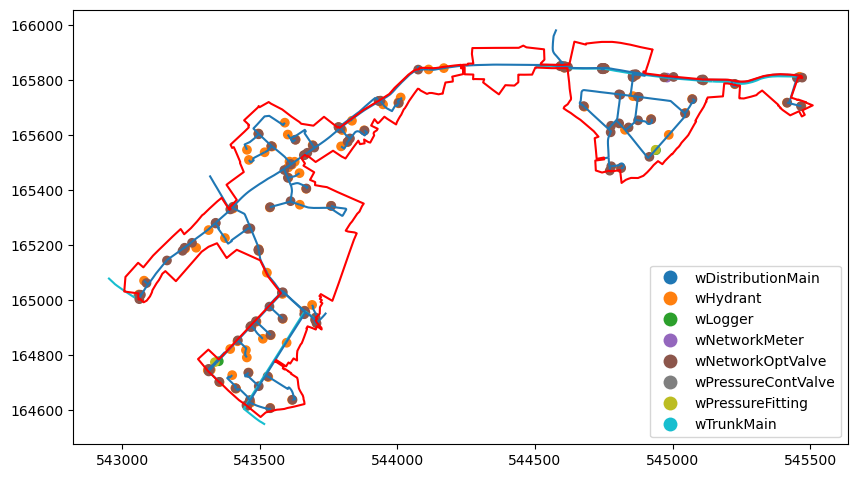

In [25]:
ax = networkdata_aoi.plot(column='Label', legend=True, figsize=(10, 12))

dma_aoi.boundary.plot(ax=ax, color='r')

plt.show()

## Query Neo4j

### Get database properties

In [26]:
# Database properties
queries = [
    "CALL db.labels()",
    "CALL db.relationshipTypes()",
    "CALL db.propertyKeys()",
    #"CALL db.schema.visualization()"
]

with driver.session() as session:
    for query in queries:
        print(query)
        result = session.run(query)
        for record in result:
            print(record)

CALL db.labels()
<Record label='PipeEnd'>
<Record label='PointNode'>
<Record label='Hydrant'>
<Record label='PointAsset'>
<Record label='NetworkMeter'>
<Record label='PressureControlValve'>
<Record label='Chamber'>
<Record label='OperationalSite'>
<Record label='PressureFitting'>
<Record label='Logger'>
CALL db.relationshipTypes()
<Record relationshipType='TRUNKMAIN'>
CALL db.propertyKeys()
<Record propertyKey='gid'>
<Record propertyKey='pipe_type'>
<Record propertyKey='dmas'>
<Record propertyKey='weight'>


### Total Nodes & Edges

In [27]:
# Nodes and Edges
queries = [
    "MATCH (n) RETURN count(n) AS total_nodes",
    "MATCH ()-[r]->() RETURN count(r) AS total_edges"
]

with driver.session() as session:
    for query in queries:
        result = session.run(query)
        record = result.single()
        print(record)

<Record total_nodes=163191>
<Record total_edges=133618>


### Features in DMA

In [39]:
# Features according to GPKG
len(networkdata_aoi.GISID.unique())

571

In [29]:
query = "MATCH (n) WHERE n.dmas CONTAINS 'ZWWICK06' RETURN n "

with driver.session() as session:
        result = session.run(query)
        records = [record for record in result]

In [34]:
# Nodes only 
len(records)

48

In [131]:
query = "MATCH (n)-[r]-(m) WHERE n.dmas CONTAINS 'ZWWICK06' OR m.dmas CONTAINS 'ZWWICK06' RETURN n, r, m;"

with driver.session() as session:
        result = session.run(query)
        records = [record for record in result]

In [132]:
# Nodes and edges
len(records)

48

In [133]:
session = driver.session()

w = showGraph(query)

GraphWidget(layout=Layout(height='800px', width='100%'))

Layout(height='200px', width='80%')

In [40]:
networkdata_aoi.columns

Index(['GISID', 'Label', 'geometry'], dtype='object')

In [41]:
networkdata_aoi.loc[networkdata_aoi['GISID'] == 1791668]

,GISID,Label,geometry
1356,1791668,wNetworkMeter,POINT (544979.700 165807.700)


In [42]:
m = networkdata_aoi.explore(
    column="Label",  # make choropleth 
    tooltip="Label",  
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",
    legend=True,
    #style_kwds=dict(color="black"),  # use black outline
)

folium.LayerControl().add_to(m)

m

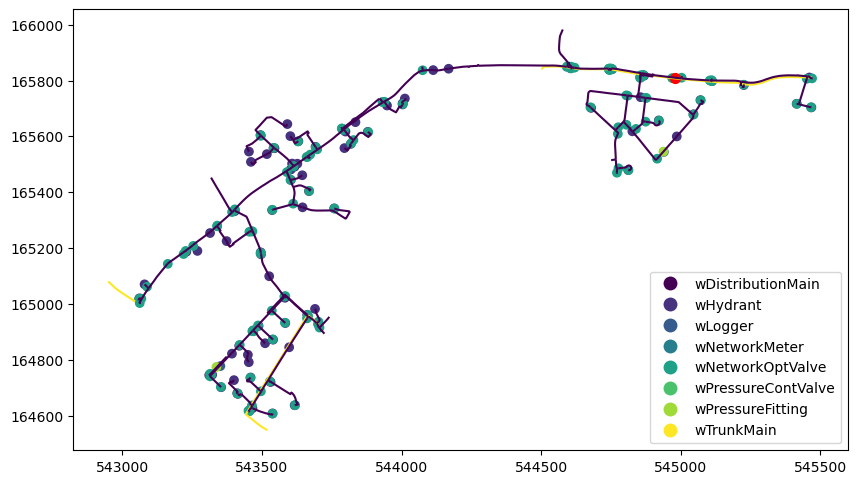

In [43]:
import matplotlib.pyplot as plt

# Plot the entire GeoDataFrame
ax = networkdata_aoi.plot(column="Label", cmap='viridis', legend=True, figsize=(10, 10))

# Slice the GeoDataFrame based on the condition
sliced_networkdata = networkdata_aoi[networkdata_aoi['GISID'] == 1791668]

# Plot the sliced GeoDataFrame on the same map
sliced_networkdata.plot(ax=ax, color='red', markersize=50)

plt.show()

## Compare GPKG & Graph assets

**Number of geospatial features per asset**

In [48]:
networkdata_aoi.groupby('Label')['GISID'].nunique()

Label
wDistributionMain     336
wHydrant               85
wLogger                 2
wNetworkMeter           2
wNetworkOptValve      126
wPressureContValve      1
wPressureFitting        2
wTrunkMain             17
Name: GISID, dtype: int64

**Number of line intersection that will be created as nodes in graph**

In [50]:
networkdata_aoi.geom_type.unique()

array(['Point', 'MultiLineString'], dtype=object)

In [79]:
from shapely.geometry import LineString

# Filter the GeoDataFrame to include only MultiLineString geometries
lines_gdf = networkdata_aoi.loc[networkdata_aoi.geom_type == 'MultiLineString']
lines_gdf = lines_gdf.explode(index_parts=True)

# Initialize an empty list to store intersection points
intersection_points = []

# Iterate over each pair of LineString geometries
for i, line1 in lines_gdf.iterrows():
    for j, line2 in lines_gdf.iterrows():
        # Check if the two lines intersect
        if line1.geometry.intersects(line2.geometry):
            # If they intersect, calculate the intersection point(s)
            intersection = line1.geometry.intersection(line2.geometry)
            # If the intersection is a single point, add it to the list
            if intersection.geom_type == 'Point':
                intersection_points.append(intersection)
            # If the intersection is a MultiPoint, add each point to the list
            elif intersection.geom_type == 'MultiPoint':
                intersection_points.extend(intersection)

# Convert the list of intersection points to a GeoDataFrame
intersection_points_gdf = gpd.GeoDataFrame(geometry=intersection_points, crs=lines_gdf.crs)

In [81]:
len(intersection_points_gdf)

934

# Points joining to multiple lines

In [37]:
geopackage = fiona.listlayers(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'))

In [38]:
geopackage

['wNetworkMeter',
 'wPressureContValve',
 'wHydrant',
 'wTrunkMain',
 'wDistributionMain',
 'wLogger',
 'wPressureFitting',
 'wOperationalSite',
 'wChamber',
 'wNetworkOptValve']

In [41]:
trunk_mains = gpd.read_file(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'), layer='wTrunkMain')
distribution_mains = gpd.read_file(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'), layer='wDistributionMain')
w_network_meter = gpd.read_file(Path(DataDir, 'tw_cleanwater_network_layers.gpkg'), layer='wNetworkMeter')

In [46]:
pipes_df = pd.concat([trunk_mains, distribution_mains])

In [47]:
# Disjoint points
intersecting = gpd.sjoin(w_network_meter, pipes_df, how='inner', predicate='intersects')
int_idx = intersecting.index.unique()
disjoint_network_meter = w_network_meter[~w_network_meter.index.isin(int_idx)]

<Axes: >

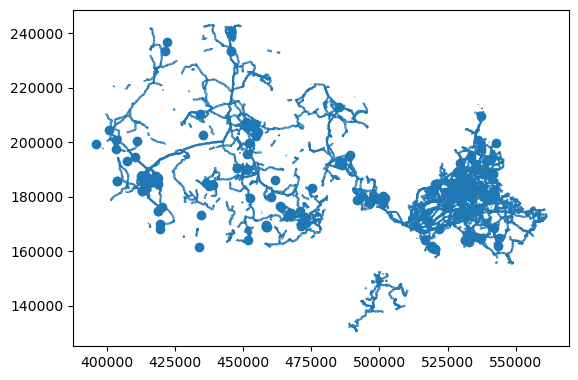

In [48]:
fig, ax = plt.subplots()

trunk_mains.plot(ax=ax)
disjoint_network_meter.plot(ax=ax)

In [49]:
disjoint_network_meter

,GISID,LIFECYCLESTATUS,SUBTYPECD,HEIGHT,SUPPLYPURPOSE,METERTYPE,METERCONTYPE,geometry
47,1793169,LIVE,4,65.97,D,VENT,U,POINT (527370.000 184882.000)
121,1795483,LIVE,4,63.70,D,VENT,U,POINT (451214.000 206458.000)
122,1795484,LIVE,4,61.98,D,UNK,U,POINT (451267.900 206043.800)
242,1795476,LIVE,4,63.40,D,UNK,U,POINT (450976.200 207301.800)
263,1795591,LIVE,4,56.91,D,VENT,U,POINT (452122.100 206298.700)
...,...,...,...,...,...,...,...,...
11660,10899500,LIVE,4,98.00,D,HLX,None,POINT (537101.402 164938.652)
11766,10924517,LIVE,4,15.01,TM,None,None,POINT (537200.672 197881.147)
11783,10937634,LIVE,4,36.20,TM,None,None,POINT (537402.194 209509.983)
11788,10936618,LIVE,4,29.95,TM,None,None,POINT (530593.845 189759.732)


# Neo4J to NetworkX

In [98]:
#! pip install networkx

In [283]:
import networkx as nx
import momepy
from contextily import add_basemap

In [289]:
driver = GraphDatabase.driver(URI, auth=AUTH)

G = nx.MultiDiGraph()

query = "MATCH (n) WHERE n.dmas CONTAINS 'ZWWICK06' RETURN n;"

results = driver.session().run(query)

nodes = list(results.graph()._nodes.values())

for node in nodes:
    G.add_node(node._properties.get('gid'), labels=node._labels, properties=node._properties)
    

query = "MATCH (n)-[r]-(m) WHERE n.dmas CONTAINS 'ZWWICK06' OR m.dmas CONTAINS 'ZWWICK06' RETURN n, r, m;"

results = driver.session().run(query)

nodes = list(results.graph()._nodes.values())

for node in nodes:
    G.add_node(node._properties.get('gid'), labels=node._labels, properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel._start_node._properties.get('gid'), rel.end_node._properties.get('gid'), 
               key=rel.element_id, 
               type=rel.type, 
               properties=rel._properties)

In [290]:
for node in nodes[:2]:
    print(node._properties.get('gid'))
    print(node._labels)
    print(node._properties)

2240217
frozenset({'PipeEnd', 'PointNode'})
{'gid': 2240217, 'dmas': '"[{\\"code\\": \\"ZFRNBO10\\", \\"name\\": \\"FARNBOROUGH\\"}]"', 'pipe_type': 'trunk_main'}
2240219
frozenset({'PipeEnd', 'PointNode'})
{'gid': 2240219, 'dmas': '"[{\\"code\\": \\"ZFRNBO10\\", \\"name\\": \\"FARNBOROUGH\\"}, {\\"code\\": \\"ZWWICK06\\", \\"name\\": \\"WEST WICKHAM\\"}]"', 'pipe_type': 'trunk_main'}


In [291]:
for rel in rels[:2]:
    print(rel._start_node._properties.get('gid'))
    print(rel.end_node._properties.get('gid'))
    print(rel.element_id)
    print(rel.type)
    print(rel._properties)

2240217
2240219
5:b589c26c-f3d1-4b7d-afe6-343ca149f6e3:3711
TRUNKMAIN
{'gid': 2240219, 'dmas': '"[{\\"code\\": \\"ZFRNBO10\\", \\"name\\": \\"FARNBOROUGH\\"}, {\\"code\\": \\"ZWWICK06\\", \\"name\\": \\"WEST WICKHAM\\"}]"', 'weight': 1.0}
2240219
2240220
5:b589c26c-f3d1-4b7d-afe6-343ca149f6e3:3713
TRUNKMAIN
{'gid': 2240220, 'dmas': '"[{\\"code\\": \\"ZWWICK06\\", \\"name\\": \\"WEST WICKHAM\\"}]"', 'weight': 1.0}


In [292]:
networkdata_aoi = networkdata_aoi.explode(index_parts=True)

### Get Node positions in graph from geodataframe

In [293]:
positions = {}

for node in list(G.nodes):
    if node in networkdata_aoi.GISID.unique():
        #print(f'{node} in networkdata_aoi')
        dftmp = networkdata_aoi.loc[networkdata_aoi.GISID == node]
        if dftmp.geom_type.iloc[0] == 'Point':
            point = dftmp.geometry.iloc[0]
            # Extract x and y coordinates
            x, y = point.x, point.y
            positions[node] = [x, y]
        elif dftmp.geom_type.iloc[0] == 'LineString':
            positions[node] = dftmp.iloc[0]['geometry'].coords[0]
        else:
            print(f'{node} not in networkdata_aoi')

In [294]:
# List of nodes to delete based on certain condition (e.g., a property)
nodes_to_delete = []


for i in list(G.nodes):
    if i in positions:
        continue
    else:
        nodes_to_delete.append(i)

# Delete nodes from the graph
for node_id in nodes_to_delete:
    G.remove_node(node_id)

## Create Graph just with nodes - not all data loaded in graph yet

In [274]:
G = nx.MultiDiGraph()

query = "MATCH (n) WHERE n.dmas CONTAINS 'ZWWICK06' RETURN n;"

results = driver.session().run(query)

nodes = list(results.graph()._nodes.values())

for node in nodes:
    G.add_node(node._properties.get('gid'), labels=node._labels, properties=node._properties)

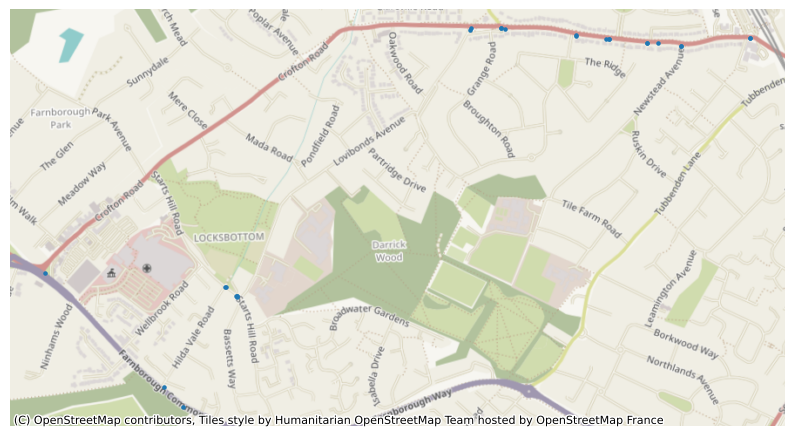

In [282]:
f, ax = plt.subplots(figsize=(10, 6))

nx.draw(G, positions, ax=ax, node_size=5)
add_basemap(ax, crs=lines_gdf.crs)

## Create Test NetworkX Graph from Pipes data

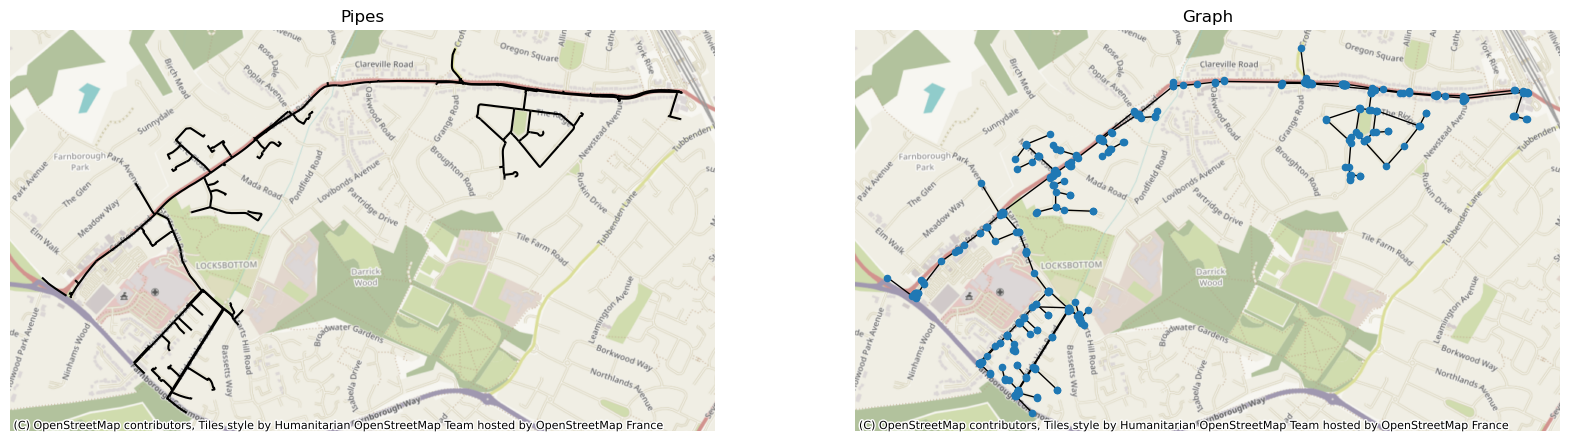

In [285]:
# Construct the primal graph
G_primal = momepy.gdf_to_nx(lines_gdf, approach="primal")

positions = {n: [n[0], n[1]] for n in list(G_primal.nodes)}
# Plot
f, ax = plt.subplots(1, 2, figsize=(20, 15), sharex=True, sharey=True)
lines_gdf.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Pipes", "Graph")[i])
    facet.axis("off")
    add_basemap(facet, crs=lines_gdf.crs)
nx.draw(
    G_primal,positions, ax=ax[1], node_size=20
)

In [151]:
G_primal.number_of_nodes()

350

In [153]:
G_primal.number_of_edges()

353

In [159]:
for i in G_primal.nodes.data():
    print(i)

((543703.5, 164925.5), {})
((543702.5, 164926.5), {})
((545110.0, 165796.0), {})
((545144.7000000002, 165793.69999999925), {})
((543701.2000000002, 164927.80000000075), {})
((545226.5, 165786.5), {})
((545461.0, 165810.90000000037), {})
((544505.2999999998, 165845.09999999963), {})
((544607.2999999998, 165845.69999999925), {})
((544501.9000000004, 165839.80000000075), {})
((545471.2999999998, 165809.80000000075), {})
((544969.5, 165808.80000000075), {})
((544979.7000000002, 165807.69999999925), {})
((544866.4000000004, 165821.09999999963), {})
((543664.4000000004, 164959.30000000075), {})
((543450.5999999996, 164617.80000000075), {})
((544621.7000000002, 165843.40000000037), {})
((543045.7000000002, 165008.40000000037), {})
((542949.2999999998, 165080.30000000075), {})
((543519.2999999998, 164547.30000000075), {})
((543454.5, 164618.5), {})
((543460.7999999998, 164628.5), {})
((543454.5999999996, 164615.19999999925), {})
((543455.2000000002, 164616.30000000075), {})
((543458.5, 164735.

# Next Steps:
- calc num pipesin dma
- -num pipe ends in dma
- filter by dma (graph)
- compare